# VLSI - SMT Part
Di Tuccio Gianluca, Orsini Lorenzo

In [1]:
from tqdm import tqdm
from z3 import *
from numpy import random
import os
import pandas as pd

random_seed = 42

'''
SET HERE THE PATH OF THE MAIN FOLDER (i.e VLSI folder)
            |
            |
            V
'''
os.chdir('/Users/gianlucadituccio/Documents/VLSI')
from utils.utils import *

In [2]:
def cumulative(position, duration, resources, limit, w):
    clauses = []
    for i in range(w):
        clauses.append(Sum([If(And(position[j] <= i, position[j] + duration[j] > i), 
                               resources[j], 0) for j in range(len(position))])<=limit)
    return clauses

## Results

In [15]:
results = pd.read_csv('utils/datasets/SMT_h.csv').replace(np.nan, 'N/A')
results = results.reset_index(drop=True)
results = results.set_index("Instance")
results.applymap(lambda x: int(x) if x !='N/A' else x).style.apply(highlight_h_min, axis=1)

,h_min,SMT w/out SB w/out R,SMT + SB w/out R,SMT w/out SB + R,SMT + SB + R
Instance,,,,,
1,8,8,8,8,8
2,9,9,9,9,9
3,10,10,10,10,10
4,11,11,11,11,11
5,12,12,12,12,12
6,13,13,13,13,13
7,14,14,14,14,14
8,15,15,15,15,15
9,16,16,16,16,16


In [11]:
results = pd.read_csv('utils/datasets/SMT_time.csv')
Statistics({'SMT w/out SB w/out R':results['SMT w/out SB w/out R'],
            'SMT + SB w/out R':results['SMT + SB w/out R'],
            'SMT w/out SB + R':results['SMT w/out SB + R'],
            'SMT + SB + R':results['SMT + SB + R']})
results = results.replace('H', 0)
results = results.astype(float)
results = results.reset_index(drop=True)
results = results.set_index("Instance")
print()
print('GREEN --> BEST VALUE,\nYELLOW --> WORST VALUE,\nRED --> TIMEOUT')
results.style.apply(highlight_max, axis=1).apply(highlight_min, axis=1).apply(highlight_timeout, axis=1).set_properties(**{'border-top': '2px solid', 'border-bottom': '2px solid'}, axis=1)

TIMEOUT is seen as 300s.

Non Optimal solution has required 300s.

+---------------------------------+----------------------+------------------+------------------+--------------+
|                                 | SMT w/out SB w/out R | SMT + SB w/out R | SMT w/out SB + R | SMT + SB + R |
+---------------------------------+----------------------+------------------+------------------+--------------+
|          Total Time [s]         |              2194.59 |         2060.039 |         6696.672 |     3870.686 |
|             Max [s]             |                300.0 |            300.0 |            300.0 |        300.0 |
|             Min [s]             |                0.037 |            0.035 |            0.031 |        0.047 |
|             Mean [s]            |               54.865 |           51.501 |          167.417 |       96.767 |
|             Std [s]             |              104.706 |           99.084 |          137.453 |      134.332 |
| Instances Solved with H optimal |  

,SMT w/out SB w/out R,SMT + SB w/out R,SMT w/out SB + R,SMT + SB + R
Instance,,,,
1.0,0.037005,0.035216,0.030943,0.052720
2.0,0.042264,0.038764,0.037763,0.047450
3.0,0.062056,0.054940,0.049823,0.067034
4.0,0.075772,0.067312,0.077039,0.091781
5.0,0.106780,0.098915,0.416562,0.127041
6.0,0.142476,0.128067,1.174385,0.178411
7.0,0.135050,0.139224,0.455149,0.174842
8.0,0.193946,0.175245,0.734305,0.321459
9.0,0.186038,0.170492,1.508122,0.244135


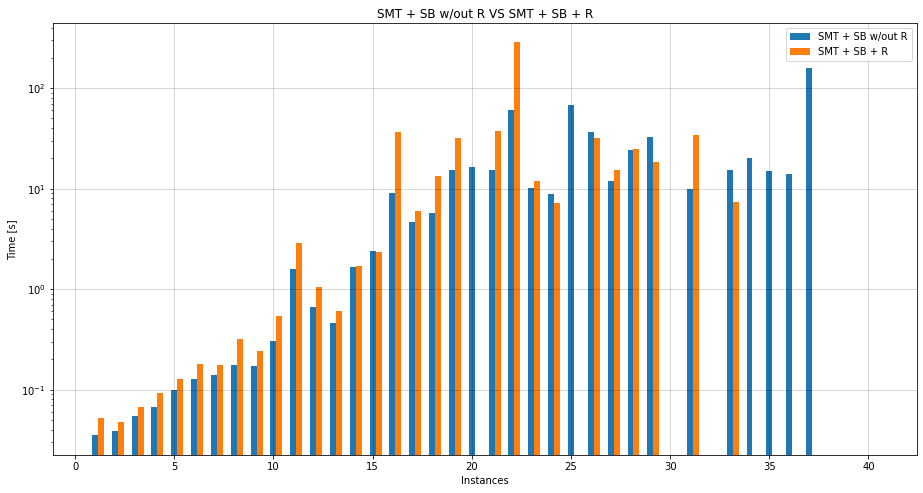

In [6]:
PlotStats({'SMT + SB w/out R':results['SMT + SB w/out R'], 
            'SMT + SB + R':results['SMT + SB + R']},
            x_axis=list(pd.read_csv('utils/datasets/SMT_time.csv')['Instance']))

## SMT without Rotation

In [ ]:
def SMT(parameters, height, timeout=300, simmetry=False):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        set_param('smt.random_seed', random_seed)
        solver = Optimize()  
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        
        # declaration of the plate (i.e. all possible coordinates)
        # in this case we've used INT array instead a BOOL matrix
        x_positions = [Int(f"px_{i+1}") for i in range(n)]
        y_positions = [Int(f"py_{i+1}") for i in range(n)]

        # declaration of the left-right rectangles positions
        lr = [[Bool(f"lr_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles]
        
        h_min = parameters['min_h']
        h_max = sum(y_components)
        
        h = Int('height')
        solver.add(h>=h_min)
        solver.add(h<=h_max)
        
        if simmetry:
            solver.add(x_positions[0]==0)
            solver.add(y_positions[0]==0)
            
            for i in range(n):
                for j in range(i+1,n):
                    # same rectangles constraint (PAPER)
                    solver.add(If(x_components[i]==x_components[j] and y_components[i]==y_components[j], 
                                  And(Not(lr[j][i]), Or(lr[i][j], ud[j][i])), True))
                    
        # cumulative constraint
        solver.add(cumulative(x_positions, x_components, y_components, h, w))
        
        for i in range(n):
            
            # POSITION CONSTRAINTS
            solver.add(x_positions[i]+x_components[i]<=w)
            solver.add(y_positions[i]+y_components[i]<=h)
            
            # POSITIONs >= 0
            solver.add(x_positions[i]>=0)
            solver.add(y_positions[i]>=0)
        
            # NO OVERLAP CONSTRAINTS
            for j in range(i+1, n):
                solver.add((x_positions[i]+x_components[i] <= x_positions[j]) == lr[i][j])
                solver.add((y_positions[i]+y_components[i] <= y_positions[j]) == ud[i][j])
                solver.add((x_positions[j]+x_components[j] <= x_positions[i]) == lr[j][i])
                solver.add((y_positions[j]+y_components[j] <= y_positions[i]) == ud[j][i])
                solver.add(Sum(If(lr[i][j],1,0), If(lr[j][i],1,0), If(ud[i][j],1,0), If(ud[j][i],1,0))>=1)
            if t_constraint>timeout*1000: return {}
            
            # large rectangles constraint (SAT PAPER)
            for j in range(i+1,n):
                solver.add(If(x_components[i]+x_components[j]>w, lr[i][j] == False and lr[j][i] == False, True))
                solver.add(If(y_components[i]+y_components[j]>h, ud[i][j] == False and ud[j][i] == False, True))
 
            if t_constraint>timeout*1000: return {}
            
        solver.set("timeout", timeout*1000-int(t_constraint))
        solver.minimize(h)
        
        if solver.check() == sat:
            solution = solver.model()
            
            output = {}
            output['h'] = solution.evaluate(h).as_long()  
            output['W'] = w
            
            x_pos = []
            for i in x_positions:
                x_pos.append(solution.evaluate(i).as_long())
            
            y_pos = []
            for i in y_positions:
                y_pos.append(solution.evaluate(i).as_long())
                
            # re-take the original order of the rectangles
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(x_pos, y_pos, x_components, y_components, original_indices)]
            x_pos, y_pos, x_components, y_components, _ = zip(*sorted(positions, key=lambda x: x[4]))
            
            output['x_positions'] = x_pos
            output['y_positions'] = y_pos
            output['x_components'] = x_components
            output['y_components'] = y_components
            
            return output
        return {}
        
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(30,31)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    result = SMT(parameters=file, height=file['min_h'], timeout=300, simmetry=True)
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result)
        PlotInstance(result, 
                     path='SMT/images', 
                     name='fig-'+str(i))
        WriteInstance(result,
                     path='SMT/out',
                     name='out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## SMT with Rotation

In [ ]:
def SMTRotation(parameters, timeout=300, simmetry=False):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        set_param('smt.random_seed', random_seed)
        solver = Optimize()
        
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        
        # declaration of the plate (i.e. all possible coordinates)
        # first index --> rectangle; second index --> coordinates from 0 to w
        px = [Int(f"px_{i+1}") for i in range(n)]
        
        # first index --> rectangle; second index --> coordinates from 0 to height
        py = [Int(f"py_{i+1}") for i in range(n)]

        # declaration of the left-right rectangles positions
        lr = [[Bool(f"lr_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        
        # rotation
        rot = [Bool(f"rot_{i+1}") for i in range(n)]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles] 
        
        x_components_rotated = [Int(f"x_comp_rot_{i+1}") for i in range(n)]
        y_components_rotated = [Int(f"y_comp_rot_{i+1}") for i in range(n)]
        
        h_min = parameters['min_h']
        h_max = sum(y_components)
        
        h = Int('height')
        solver.add(h>=h_min)
        solver.add(h<=h_max)
        
        if simmetry:
            # higher rectangle in (0,0) and rot set to False
            solver.add(px[0]==0)
            solver.add(py[0]==0)
            solver.add(rot[0]==False)
            
            for i in range(n):
                for j in range(i+1,n):
                    # same rectangles constraint (PAPER)
                    solver.add(If(x_components[i]==x_components[j] and y_components[i]==y_components[j], 
                                  And(Not(lr[j][i]), Or(lr[i][j], ud[j][i])), True))
                
                # if the rectangle has the same components
                solver.add(If(x_components[i]==y_components[i], rot[i]==False, True))
        
        # cumulative constraint
        solver.add(cumulative(px, x_components, y_components, h, w))
        
        for i in range(n):
            solver.add(If(y_components[i]>w, rot[i]==False, True))
            solver.add(If(x_components[i]>h, rot[i]==False, True))
            
            # position constraints
            solver.add(px[i]+x_components_rotated[i]<=w)
            solver.add(py[i]+y_components_rotated[i]<=h)
            
            # positions >= 0
            solver.add(px[i]>=0)
            solver.add(py[i]>=0)
            
            # rotation
            solver.add(If(rot[i], x_components_rotated[i]==y_components[i], x_components_rotated[i]==x_components[i]))
            solver.add(If(rot[i], y_components_rotated[i]==x_components[i], y_components_rotated[i]==y_components[i]))             
            
            # Non overlapping constraints
            for j in range(i+1, n):
                solver.add((px[i]+x_components_rotated[i] <= px[j]) == lr[i][j])
                solver.add((py[i]+y_components_rotated[i] <= py[j]) == ud[i][j])
                solver.add((px[j]+x_components_rotated[j] <= px[i]) == lr[j][i])
                solver.add((py[j]+y_components_rotated[j] <= py[i]) == ud[j][i])
                solver.add(Sum(If(lr[i][j],1,0), If(lr[j][i],1,0), If(ud[i][j],1,0), If(ud[j][i],1,0))>=1)
                
                # if two rectangles exceed the plate limit
                solver.add(If(x_components_rotated[i]+x_components_rotated[j]>w, lr[i][j] == False and lr[j][i] == False, True))
                solver.add(If(y_components_rotated[i]+y_components_rotated[j]>h, ud[i][j] == False and ud[j][i] == False, True))
    
        solver.set("timeout", timeout*1000-int(t_constraint))
        solver.minimize(h)
        
        if solver.check() == sat:
            solution = solver.model()
            output = {}
            output['h'] = solution.evaluate(h).as_long()  
            output['W'] = w
            
            x_positions = []
            for i in px:
                x_positions.append(solution.evaluate(i).as_long())
            
            y_positions = []
            for i in py:
                y_positions.append(solution.evaluate(i).as_long())
            
            rota = [False if str(solution.evaluate(rot[index]))=='False' else True for index in range(n)]
            tmp1 = [y_components[i] if rota[i] else x_components[i] for i in range(len(x_components))]
            y_components = [x_components[i] if rota[i] else y_components[i] for i in range(len(y_components))]
            x_components = tmp1
            
            output['x_positions'] = x_positions
            output['y_positions'] = y_positions
            output['x_components'] = x_components
            output['y_components'] = y_components
            output['rotation'] = rota
            return output
        return {}
        
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    result = SMTRotation(parameters=file, timeout=300, simmetry=True)
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='SMT/images', 
                     name='rotation_fig-'+str(i))
        WriteInstance(result,
                     path='SMT/out',
                     name='rotation_out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')